## Setup

In [13]:
%matplotlib widget

from pyCascade import probePost, physics
from matplotlib import pyplot as plt
import numpy as np

run = 4
category =  "single_family"


In [14]:
# ############ CLUSTER ################
# scratch_dir = '/scratch/users/nbachand/Cascade/city_block_cfd'
# home_dir = '/home/users/nbachand/Cascade/city_block_cfd'

########### LOCAL ###################
home_dir = '/home/nbachand/Documents/Cascade/city_block'
scratch_dir = home_dir

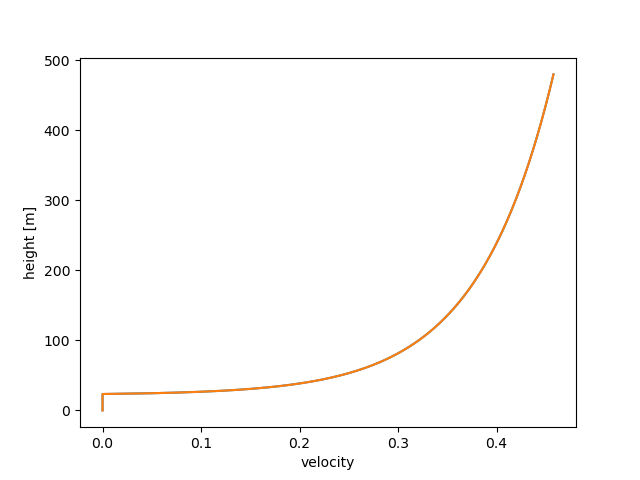

In [15]:
rho = 1.225
mu = 1.7894e-5
Re_tau = 43300
Lz =  480
hm = 20
fric_vel = Re_tau*mu/(hm*rho)

z_0 = 0.061*hm #used for convention, but really y_0
disp = 1.11*hm
shear_vel = fric_vel*np.sqrt(1-disp/Lz)
vK_const = 0.4

LES_params = {
    'uStar': shear_vel,
    'z0': z_0,
    'disp': disp,
    'vK_const': vK_const,
    'Dt': 2,
    'z_values' : np.linspace(0,Lz,Lz*10)
}
physics_setup = physics.LES_Physics(LES_params)
physics_setup.plot_log_wind()

# checking against charles code
# approximate log law mean profile
y_scaled = (LES_params['z_values']-disp)/z_0
y_scaled = np.maximum(1.0, y_scaled)
ux = (shear_vel/vK_const)*np.log(y_scaled)

plt.plot(ux, LES_params['z_values'])

In [16]:
physics_setup.calc_flatplate_quantities(
    rho = 1.224,
    mu = 1.7894e-5,
    yPlus = 500
    )


U infinity is 0.45768224669677254 with L = 480.0
flat plate Reynolds number is 15027242.29234871
wall spacing is 0.45603115286411516 for y+ of 500


In [17]:
physics_setup.LES_params['uStar']


0.03088492282600406

In [18]:
probes = probePost.Probes(f'{scratch_dir}/CHARLES/{category}/R{run}/probes/probesOut')
probes.get_locations(f'{scratch_dir}/CHARLES/{category}/R{run}/probes/locations')

slicing took 0 seconds
INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


reading data took 5 seconds
memorizing data took 0 seconds
plotting took 4 seconds


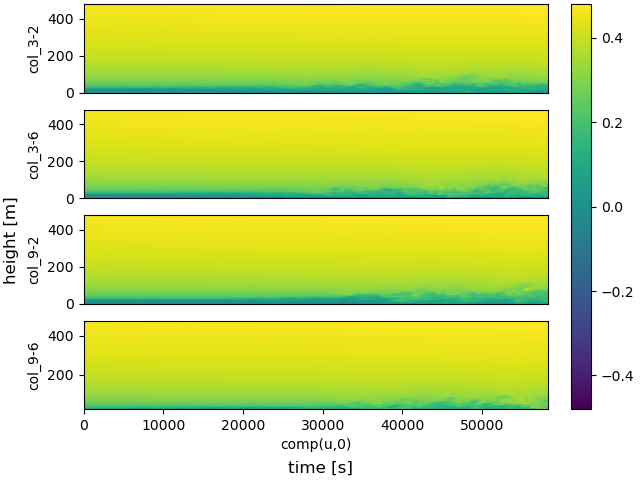

In [19]:
plot_params = {
    'plot_levels' : {
        # 'comp(u,0)' : np.linspace(0,.5,256),
        # 'comp(u,2)' : np.linspace(-1,1,256)
    },
    'horizontal spacing' : physics_setup.LES_params['Dt'],
    'stack span' : 'y',
    'xlabel': 'time [s]',
    'ylabel' : 'height [m]',
    'ColorNorm': 'Centered'
}

# slice = probes.slice_into_df(slice_params)
(fig, ax) = probes.contour_plots(
    names = [name for name in  probes.probe_names if "col" in name], 
    steps = probes.probe_steps[0:-10:10],
    quants = ['comp(u,0)'],
    parrallel = True,
    plot_params = plot_params
    )


In [ ]:
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/velocity_contour')

slicing took 0 seconds
INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


reading data took 175 seconds
memorizing data took 15 seconds
processing data took 7 seconds


TypeError: Length of x (175) must match number of columns in z (17442)

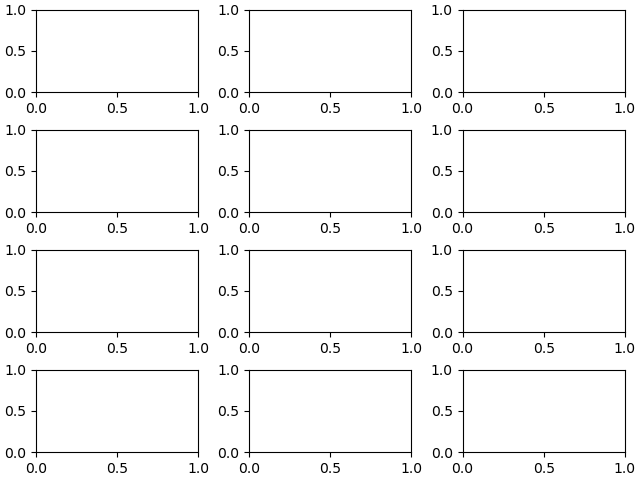

In [8]:
plot_params = {
    'plot_levels' : {
        'comp(u,0)' : np.linspace(0,.1,200),
        'comp(u,1)' : np.linspace(0,.1,200),
        'comp(u,2)' : np.linspace(0,.1,200)
    },
    'horizontal spacing' : physics_setup.LES_params['Dt'],
    'stack span' : 'y',
    'xlabel': 'time [s]',
    'ylabel' : 'height',
    'plot_every': 100
}

# slice = probes.slice_into_df(slice_params)
(fig, ax) = probes.contour_plots(
    names = [name for name in  probes.probe_names if "col" in name], 
    steps = probes.probe_steps[:-10:1],
#     quants = ['comp(u,0)', 'comp(u,1)'],
    parrallel = True,
    processing = [probePost.mean_convergence],
    plot_params = plot_params
    )

In [11]:
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/velocity_convergence')

slicing took 0 seconds
reading data took 5 seconds
memorizing data took 0 seconds


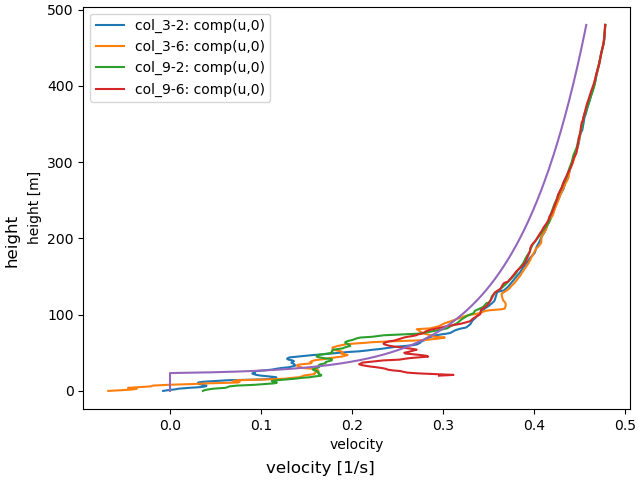

In [6]:
probes.profile_plots(
    names = [name for name in  probes.probe_names if "col" in name], 
    steps = probes.probe_steps[-100:-10],
    quants = ['comp(u,0)'],
    # stack = np.arange(0,300),
    plot_params = {
        'stack span' : 'y',
        'xlabel': 'velocity [1/s]',
        'ylabel' : 'height'
        },
    parrallel=False
    )

physics_setup.plot_log_wind()

In [26]:
plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/velocity_profile')

In [13]:
video_dir = f'{home_dir}/CHARLES/{category}/R{run}/Videos'
video_series = "u_y2"

!pwd
!echo "saving videos to: "
%cd $video_dir
!python $PYCASCADE_PATH/png2video.py --directory ../Images --namefmt "u_y2". --dt .1 --subsample 1
# !python $PYCASCADE_PATH/png2video.py --directory ../Images --namefmt "u_y5". --dt 2 --subsample 1
# !python $PYCASCADE_PATH/png2video.py --directory ../Images --namefmt "u_y8". --dt 2 --subsample 1
# !python $PYCASCADE_PATH/png2video.py --directory ../Images --namefmt "u_y20". --dt 2 --subsample 1
!echo "returning to: "
%cd -

/home/nbachand/Documents/Cascade/city_block
saving videos to: 
/home/nbachand/Documents/Cascade/city_block/CHARLES/single_family/R4/Videos
creating video...
creating video took 4 seconds
returning to: 
/home/nbachand/Documents/Cascade/city_block
